# Analysis of air-sea CO2 flux data, with explicit decomposition of abiotic vs. biotic components, in historical and future simulation

*Hilary I. Palevsky, CMIP6 Hackathon*

This script extracts total air-sea CO2 flux, as well as simulated abiotic and natural components of the total flux. By taking the difference between the toal and these subsets, it enables distinction between abiotic and biotic components of flux and between natural and anthropogenic components of flux.

For now, the only simulations that provide these components of air-sea CO2 flux are from CESM. This script focuses on abiotic vs. biotic components of flux, but extracts and processes the output needed to also distinguish natural vs. anthropogenic flux as well.

Steps this script accomplishes are:
 1. Extract historical and future scenario (SSP 585) climatologies (for now just from a single ensemble member)
 2. Calculate monthly climatology over the full historical period
 3. Visualizes historical monthly climatology at at set of time series sites (focusing on biotic vs. abiotic air-sea CO2 flux)
 4. Calculates decadal climatologies for SSP simulation 585 period (21st century)
 5. Visualizes comparison between beginning and end of the 21st century decadal climatologies under SSP 585 for time series sites
 6. Visualizes comparison between historical and end of the 21st century decadal climatologies in monthly maps

In [1]:
%matplotlib inline

import xarray as xr
import intake

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cartopy.crs as ccrs

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 1181151 entries:
	> 17 activity_id(s)

	> 24 institution_id(s)

	> 50 source_id(s)

	> 82 experiment_id(s)

	> 164 member_id(s)

	> 35 table_id(s)

	> 1036 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 253 version(s)

	> 8129 time_range(s)

	> 1181151 path(s)

### Search and discovery

#### Finding unique entries
Let's query the data to see what models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id") are available.

In [3]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 82,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', '1pctCO2-cdr',
                              'amip-future4K', 'amip-m4K', 'a4SST', 'aqua-p4K',
                              'piSST', 'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer', 'hist-nat',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-

#### Searching for specific datasets

Find all the dpCO2 (absolute, natural, and abiotic) at monthly frequency (Omon) from the ocean for the `historical` and `ssp585` experiments. Note that data are currently available only at monthly, not at annual frequency.

Relevant variables: dpco2, dpco2abio, dpco2nat; fgco2, fgco2abio, fgco2nat

Check which models have usable data. Require models to have *both* `historical` and `ssp585` data as well as both the the abiotic and natural data (not just absolute flux). At time of creation of this notebook, this only found CESM2 output.

In [4]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical', 'ssp585']: # removing this requirement for the scenario mip b/c of known issue w/ CESM eplained by K. Lindsay, 'ssp585'
    query = dict(experiment_id=experiment_id, table_id='Omon', 
                 variable_id='dpco2abio', grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)
models

['CESM2']

In [5]:
#Find all data for these absolute, abiotic, and natural air-sea CO2 flux data, and take first ensemble member

cat_fgco2nat = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                          variable_id='fgco2nat', grid_label='gn', source_id=models, member_id='r1i1p1f1')
cat_fgco2abio = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                           variable_id='fgco2abio', grid_label='gn', source_id=models, member_id='r1i1p1f1')
cat_fgco2 = col.search(experiment_id=['historical', 'ssp585'], table_id='Omon',
                       variable_id='fgco2', grid_label='gn', source_id=models, member_id='r1i1p1f1')

#Look at results for a single variable
cat_fgco2nat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
98436,CMIP,NCAR,CESM2,historical,r1i1p1f1,Omon,fgco2nat,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...
1092568,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,fgco2nat,gn,NaN,v20190730,201501-206412,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...
1092569,ScenarioMIP,NCAR,CESM2,ssp585,r1i1p1f1,Omon,fgco2nat,gn,NaN,v20190730,206501-210012,/glade/collections/cmip/CMIP6/ScenarioMIP/NCAR...


### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [6]:
dset_dict_fgco2 = cat_fgco2.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})
dset_dict_fgco2abio = cat_fgco2abio.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})
dset_dict_fgco2nat = cat_fgco2nat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                cdf_kwargs={'chunks': {}})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2abio' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2abio' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2nat' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 2 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'fgco2nat' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [8]:
dset_dict_fgco2.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.Omon.gn', 'ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn'])

We can access a particular dataset and make a test plot as follows.

In [9]:
# Note that a more suave implementation would index into the key dictionary from above
ds_hist_fgco2 = dset_dict_fgco2['CMIP.NCAR.CESM2.historical.Omon.gn']
ds_hist_fgco2abio = dset_dict_fgco2abio['CMIP.NCAR.CESM2.historical.Omon.gn']
ds_hist_fgco2nat = dset_dict_fgco2nat['CMIP.NCAR.CESM2.historical.Omon.gn']

ds_85_fgco2 = dset_dict_fgco2['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']
ds_85_fgco2abio = dset_dict_fgco2abio['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']
ds_85_fgco2nat = dset_dict_fgco2nat['ScenarioMIP.NCAR.CESM2.ssp585.Omon.gn']


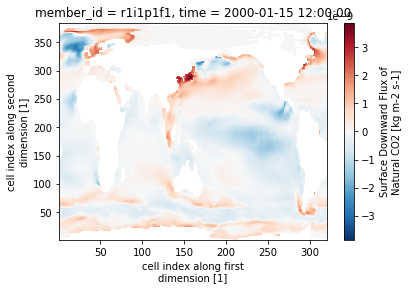

In [10]:
#Initial plotting of example data from 2000
ds_hist_fgco2nat.fgco2nat.sel(time='2000-01-15').plot()


In [11]:
#look at what xarray has in one example dataset
ds_85_fgco2nat

<xarray.Dataset>
Dimensions:    (d2: 2, member_id: 1, nlat: 384, nlon: 320, time: 1032, vertices: 4)
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) object 2015-01-15 13:00:00 ... 2100-12-15 12:00:00
Dimensions without coordinates: d2, vertices
Data variables:
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bnds  (time, d2) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    fgco2nat   (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 600, 384, 320), meta=

## Historical 12-month climatology

In [12]:
#merge datasets before calculating climatology
ds_hist_all = xr.merge([ds_hist_fgco2, ds_hist_fgco2nat, ds_hist_fgco2abio])

In [13]:
ds_hist_all

<xarray.Dataset>
Dimensions:    (d2: 2, member_id: 1, nlat: 384, nlon: 320, time: 1980, vertices: 4)
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: d2, vertices
Data variables:
    lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lat_bnds   (nlat, nlon, vertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    fgco2      (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 1980, 384, 320), met

In [14]:
#Calculate differenced properties before taking climatology
hist_fgco2bio = ds_hist_all.fgco2 - ds_hist_all.fgco2abio
ds_hist_all['fgco2bio'] = hist_fgco2bio

hist_fgco2ant = ds_hist_all.fgco2 - ds_hist_all.fgco2nat
ds_hist_all['fgco2ant'] = hist_fgco2ant

In [15]:
#Calculate climatologies and StDevs
clim_m_hist_all = ds_hist_all.groupby('time.month').mean('time')
clim_std_hist_all = ds_hist_all.groupby('time.month').std('time')

In [16]:
#Look at the xarray info for one example climatology
clim_m_hist_all

<xarray.Dataset>
Dimensions:    (member_id: 1, month: 12, nlat: 384, nlon: 320, vertices: 4)
Coordinates:
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * member_id  (member_id) <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: vertices
Data variables:
    lon        (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lat        (month, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    lon_bnds   (month, nlat, nlon, vertices) float32 dask.array<chunksize=(1, 384, 320, 4), meta=np.ndarray>
    lat_bnds   (month, nlat, nlon, vertices) float32 dask.array<chunksize=(1, 384, 320, 4), meta=np.ndarray>
    fgco2      (month, member_id, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
    fgco2nat   (month, member_id, nlat, nlon) float32 dask.

In [17]:
#Function from Riley Brady to find the i,j coordinates of a fixed lat lon point on a curvilinear grid
def find_indices(xgrid, ygrid, xpoint, ypoint):
    """Returns the i, j index for a latitude/longitude point on a grid.
    .. note::
        Longitude and latitude points (``xpoint``/``ypoint``) should be in the same
        range as the grid itself (e.g., if the longitude grid is 0-360, should be
        200 instead of -160).
    Args:
        xgrid (array_like): Longitude meshgrid (shape `M`, `N`)
        ygrid (array_like): Latitude meshgrid (shape `M`, `N`)
        xpoint (int or double): Longitude of point searching for on grid.
        ypoint (int or double): Latitude of point searching for on grid.
    Returns:
        i, j (int):
            Keys for the inputted grid that lead to the lat/lon point the user is
            seeking.
    Examples:
        >>> import esmtools as et
        >>> import numpy as np
        >>> x = np.linspace(0, 360, 37)
        >>> y = np.linspace(-90, 90, 19)
        >>> xx, yy = np.meshgrid(x, y)
        >>> xp = 20
        >>> yp = -20
        >>> i, j = et.spatial.find_indices(xx, yy, xp, yp)
        >>> print(xx[i, j])
        20.0
        >>> print(yy[i, j])
        -20.0
    """
    dx = xgrid - xpoint
    dy = ygrid - ypoint
    reduced_grid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reduced_grid)
    i, j = np.unravel_index(min_ix, reduced_grid.shape)
    return i, j

In [18]:
# Get indices for time series sites of choice - note that output is lat lon but input is ordered lon lat
HOT = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 360 - 158, 22.75)
OSP = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 360 - 150, 50)
KEO = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 144.6, 32.4)
NA = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 360-47.2, 50) #random selection by Andrea
SO = find_indices(ds_hist_fgco2.lon, ds_hist_fgco2.lat, 100, -45) #random selection by Andrea

Make a function to plot historical climatology at fixed time series points

In [19]:
def histClimPlot(timeSeriesLoc, timeSeriesName):
    plt.plot(-clim_m_hist_all.fgco2.sel(nlat=timeSeriesLoc[0],
                                        nlon=timeSeriesLoc[1]) * 10**9,
             'k',
             label='absolute flux')
    plt.plot(-clim_m_hist_all.fgco2abio.sel(nlat=timeSeriesLoc[0],
                                            nlon=timeSeriesLoc[1]) * 10**9,
             'b',
             label='abiotic flux')
    plt.plot(-clim_m_hist_all.fgco2bio.sel(nlat=timeSeriesLoc[0],
                                           nlon=timeSeriesLoc[1]) * 10**9,
             'g',
             label='biotic flux')
    plt.legend()
    plt.title(timeSeriesName + ' historical climatology')
    plt.ylabel('Air-sea CO2 flux, kg m-2 s-2*10^9')
    plt.xlabel('Month')

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/ar

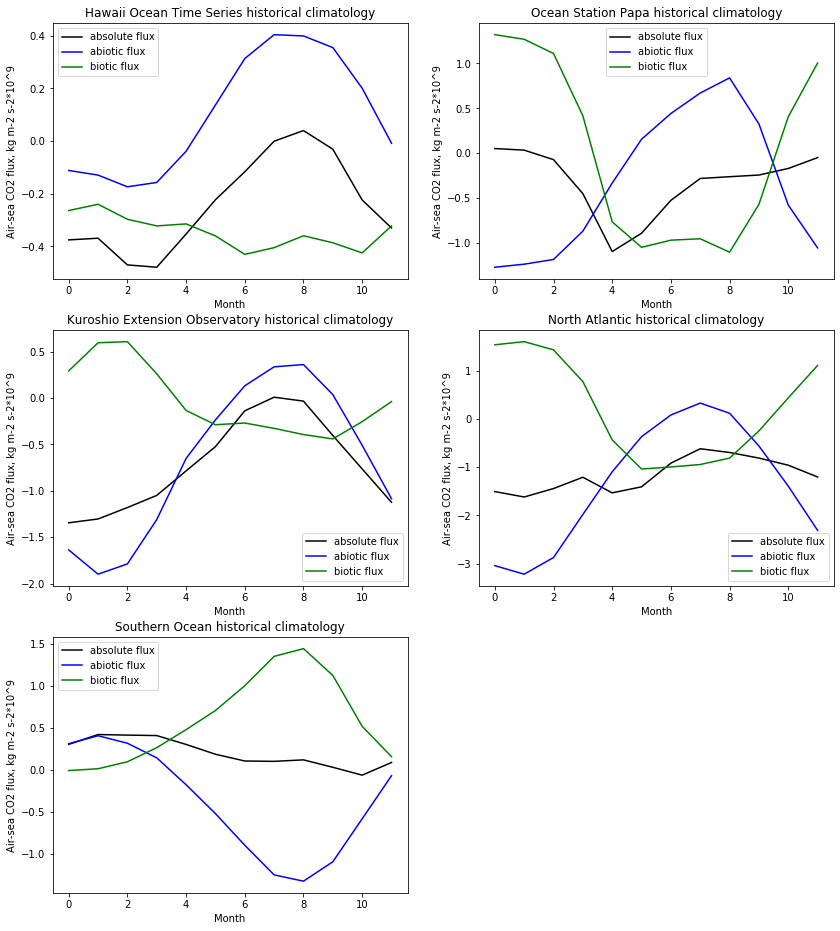

In [47]:
#Plot historical climatology at fixed time series points
fig = plt.figure(figsize=(14, 16))

ax1 = fig.add_subplot(3, 2, 1)
histClimPlot(HOT, 'Hawaii Ocean Time Series')

ax2 = fig.add_subplot(3, 2, 2)
histClimPlot(OSP, 'Ocean Station Papa')

ax3 = fig.add_subplot(3, 2, 3)
histClimPlot(KEO, 'Kuroshio Extension Observatory')

ax4 = fig.add_subplot(3, 2, 4)
histClimPlot(NA, 'North Atlantic')

ax5 = fig.add_subplot(3, 2, 5)
histClimPlot(SO, 'Southern Ocean')


# SSP 585 Climatologies

In [21]:
#merge datasets before calculating climatology
ds_85_all = xr.merge([ds_85_fgco2, ds_85_fgco2nat, ds_85_fgco2abio])

In [22]:
#Calculate differenced properties before taking climatology
ssp585_fgco2bio = ds_85_all.fgco2 - ds_85_all.fgco2abio
ds_85_all['fgco2bio'] = ssp585_fgco2bio

ssp585_fgco2ant = ds_85_all.fgco2 - ds_85_all.fgco2nat
ds_85_all['fgco2ant'] = ssp585_fgco2ant

In [23]:
# Create string of years bounding decades to loop through
dlist = np.arange(2020,2100,10)

In [24]:
# Calculate cliamtolgoies for each decade
# Start the loop. note, using enumerate allows you to link i to the index (0,1,2) and t to the values of dlist

for i, t in enumerate(dlist):
    print(str(t)+'-01-01', str(t+9)+'-12-31')
    ds_85_sub = ds_85_all.sel(time=slice(str(t)+'-01-01', str(t+9)+'-12-31'))
    m_85_sub = ds_85_sub.groupby('time.month').mean('time')
    std_85_sub = ds_85_sub.groupby('time.month').std('time')
    if i == 0:
        clim_m_85_all = m_85_sub
        clim_std_85_all = std_85_sub
    else:
        clim_m_85_all = xr.concat([clim_m_85_all, m_85_sub],dim='time')
        clim_std_85_all = xr.concat([clim_std_85_all, std_85_sub],dim='time')
    
clim_m_85_all['time'] = xr.DataArray((dlist), dims=['time'])
clim_std_85_all['time'] = xr.DataArray((dlist), dims=['time'])

2020-01-01 2029-12-31
2030-01-01 2039-12-31
2040-01-01 2049-12-31
2050-01-01 2059-12-31
2060-01-01 2069-12-31
2070-01-01 2079-12-31
2080-01-01 2089-12-31
2090-01-01 2099-12-31


In [25]:
# check decadal output final dataset
clim_m_85_all

<xarray.Dataset>
Dimensions:    (member_id: 1, month: 12, nlat: 384, nlon: 320, time: 8, vertices: 4)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * member_id  (member_id) <U8 'r1i1p1f1'
  * time       (time) int64 2020 2030 2040 2050 2060 2070 2080 2090
Dimensions without coordinates: vertices
Data variables:
    lon        (time, month, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
    lat        (time, month, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
    lon_bnds   (time, month, nlat, nlon, vertices) float32 dask.array<chunksize=(1, 1, 384, 320, 4), meta=np.ndarray>
    lat_bnds   (time, month, nlat, nlon, vertices) float32 dask.array<chunksize=(1, 1, 384, 320, 4), meta=np.ndarray>
    fgco2      (time, month, member_id, nlat, nlon) floa

In [27]:
#Create a function to plot the decadal climatology (2020s and 2090s) at fixed time series points

def futClimPlot(timeSeriesLoc, timeSeriesName):
    plt.plot(-clim_m_85_all.fgco2.sel(nlat=timeSeriesLoc[0],
                                      nlon=timeSeriesLoc[1],time=2020) * 10**9,
             'k--',
             label='2020s absolute flux')
    plt.plot(-clim_m_85_all.fgco2abio.sel(nlat=timeSeriesLoc[0],
                                          nlon=timeSeriesLoc[1],time=2020) * 10**9,
             'b--',
             label='2020s abiotic flux')
    plt.plot(-clim_m_85_all.fgco2bio.sel(nlat=timeSeriesLoc[0],
                                         nlon=timeSeriesLoc[1],time=2020) * 10**9,
             'g--',
             label='2020s biotic flux')
    plt.plot(-clim_m_85_all.fgco2.sel(nlat=timeSeriesLoc[0],
                                      nlon=timeSeriesLoc[1],time=2090) * 10**9,
             'k',
             label='2090s absolute flux')
    plt.plot(-clim_m_85_all.fgco2abio.sel(nlat=timeSeriesLoc[0],
                                          nlon=timeSeriesLoc[1],time=2090) * 10**9,
             'b',
             label='2090s abiotic flux')
    plt.plot(-clim_m_85_all.fgco2bio.sel(nlat=timeSeriesLoc[0],
                                         nlon=timeSeriesLoc[1],time=2090) * 10**9,
             'g',
             label='2090s biotic flux')
    plt.legend()
    plt.title(timeSeriesName)
    plt.ylabel('Air-sea CO2 flux, kg m-2 s-2*10^9')
    plt.xlabel('Month')

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/ar

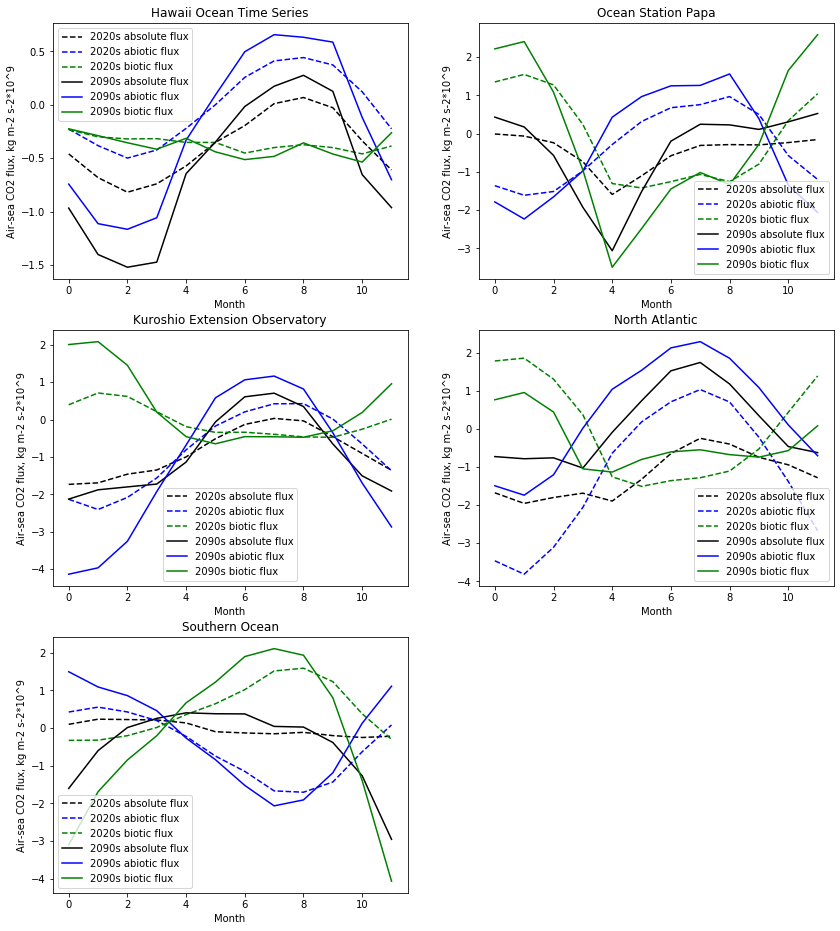

In [48]:
#Plot decadal climatology (beginning and end of century) at fixed time series points

fig = plt.figure(figsize=(14, 16))

ax1 = fig.add_subplot(3, 2, 1)
futClimPlot(HOT, 'Hawaii Ocean Time Series')

ax2 = fig.add_subplot(3, 2, 2)
futClimPlot(OSP, 'Ocean Station Papa')

ax3 = fig.add_subplot(3, 2, 3)
futClimPlot(KEO, 'Kuroshio Extension Observatory')

ax4 = fig.add_subplot(3, 2, 4)
futClimPlot(NA, 'North Atlantic')

ax5 = fig.add_subplot(3, 2, 5)
futClimPlot(SO, 'Southern Ocean')


In [44]:
# Functions to plot difference maps between historical and end of SSP585

#General function for plotting a simple contour map of input data
def mapPlot(dataToPlot, plotTitle, levels):
    dataToPlot.plot(levels=levels)
    plt.title(plotTitle)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')

#Specific function to enable plotting of a given month's CO2 flux components in the historical period, 2090s, and their difference
def mapPlotCO2ChangeByMonth(month_sel, monthName):
    ax1 = fig.add_subplot(3, 3, 1)
    dataToPlot = (-clim_m_hist_all.fgco2 * (10**9)).sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' historical air-sea co2 flux', levels)
    
    ax2 = fig.add_subplot(3, 3, 2)
    dataToPlot = (-clim_m_hist_all.fgco2abio * (10**9)).sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' historical abiotic air-sea co2 flux', levels)
    
    ax3 = fig.add_subplot(3, 3, 3)
    dataToPlot = (-clim_m_hist_all.fgco2bio * (10**9)).sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' historical biotic air-sea co2 flux', levels)
    
    ax4 = fig.add_subplot(3, 3, 4)
    dataToPlot = (-clim_m_85_all.fgco2 * (10**9)).sel(month = month_sel, 
                                                      time = 2090)
    mapPlot(dataToPlot, monthName + ' 2090s air-sea co2 flux', levels)
    
    ax5 = fig.add_subplot(3, 3, 5)
    dataToPlot = (-clim_m_85_all.fgco2abio * (10**9)).sel(month = month_sel, 
                                                          time = 2090)
    mapPlot(dataToPlot, monthName + ' 2090s abiotic air-sea co2 flux', levels)
    
    ax6 = fig.add_subplot(3, 3, 6)
    dataToPlot = (-clim_m_85_all.fgco2bio * (10**9)).sel(month = month_sel, 
                                                         time = 2090)
    mapPlot(dataToPlot, monthName + ' 2090s biotic air-sea co2 flux', levels)
    
    ax7 = fig.add_subplot(3, 3, 7)
    dataToPlot = (-clim_m_85_all.fgco2 * (10**9)).sel(month = month_sel, 
                                                      time = 2090)
    - (-clim_m_hist_all.fgco2 * (10**9)).sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' 2090s change from historical air-sea co2 flux', levels)
    
    ax8 = fig.add_subplot(3, 3, 8)
    dataToPlot = (-clim_m_85_all.fgco2abio * (10**9)).sel(month = month_sel, 
                                                      time = 2090)
    - (-clim_m_hist_all.fgco2abio * (10**9)).sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' 2090s change from historical abiotic air-sea co2 flux', levels)
    
    ax9 = fig.add_subplot(3, 3, 9)
    dataToPlot = (-clim_m_85_all.fgco2bio * (10**9)).sel(month = month_sel, 
                                                      time = 2090)
    - (-clim_m_hist_all.fgco2bio * (10**9)).sel(month = month_sel)
    mapPlot(dataToPlot, monthName + ' 2090s change from historical biotic air-sea co2 flux', levels)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/ar

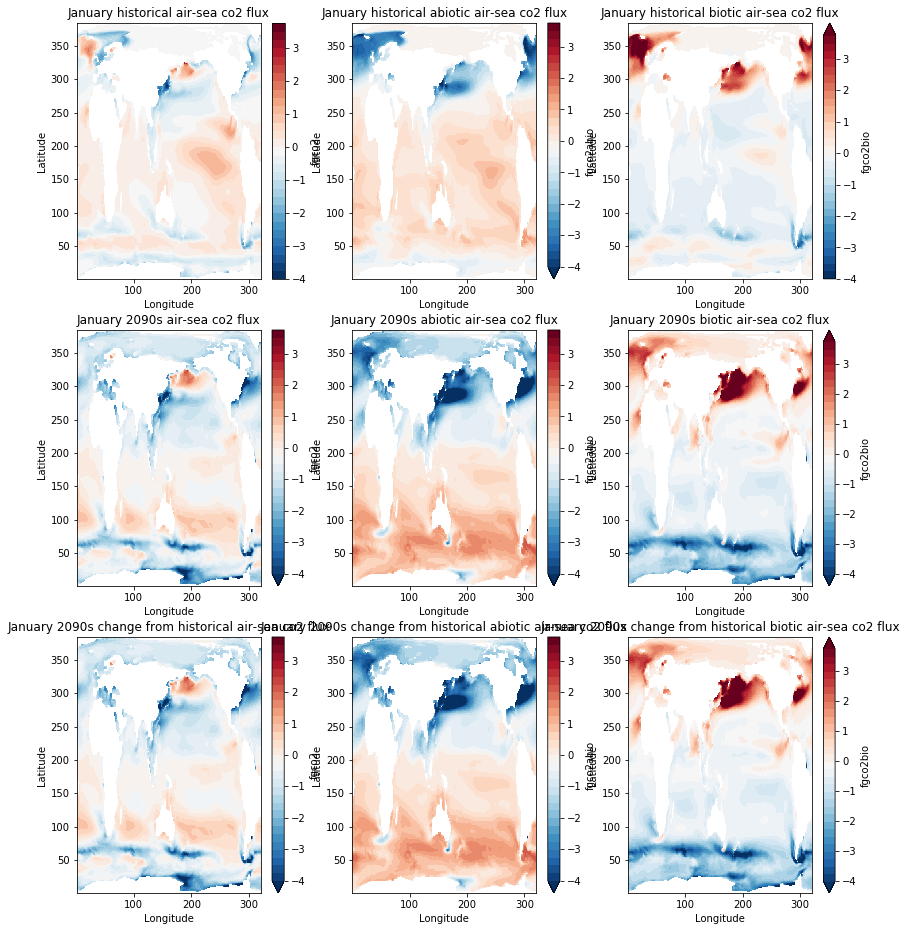

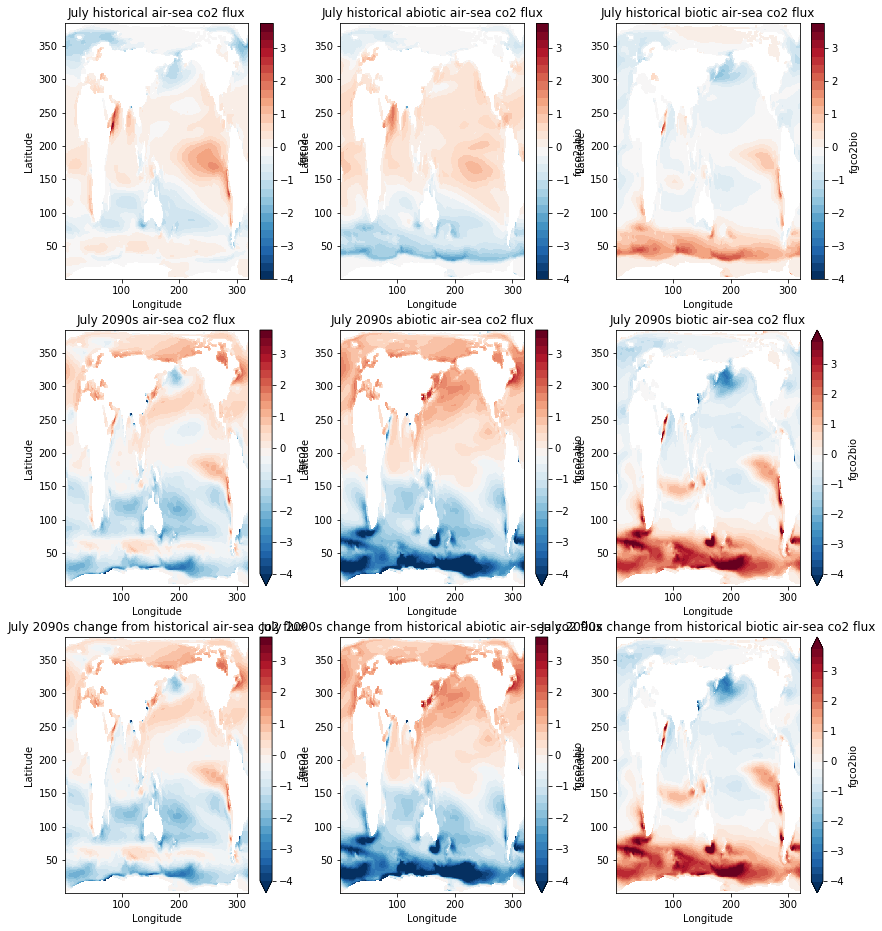

In [46]:
#Set gridding intervals for plotting
levels = np.arange(-4, 4, 0.25)

# Plot for January
fig = plt.figure(figsize=(14, 16))
mapPlotCO2ChangeByMonth(1, 'January')

#Plot for July
fig = plt.figure(figsize=(14, 16))
mapPlotCO2ChangeByMonth(7, 'July')

## Summary of results
Biotic and abiotic influences show opposite seasonal cycles, evident both in time series point climatologies earlier in the notebook and in the map views in these final plots. In general, the strength of both the abiotic and biotic seasonal cycles intensifies over the 21st century under SSP 585. The strengthening abiotic seasonal cycle dominates in driving the changes to total air-sea CO2 flux, though with notable exceptions (band ~40-60S and in the N Pacific) where biotic intensitification instead dominates.

# Proposed next steps for analysis:
1. Visualize natural and anthropogenic components of air-sea CO2 flux, comparable to what has already been done here for biotic vs. abiotic flux.
2. Calculate changes in overall and biotic/abiotic and natural/anthropogenic components of air-sea CO2 flux integrated both globally and over regions (extracted using WOA regional masks).
3. Expand analysis to include all ensemble members, rather than just single member included here.
4. Compare the biotic vs. abiotic calculation included as explicit model variables with methods applicable to observations and models that do not include these variables (i.e. Takahashi decomposion) - this can then be used as a component of a multi-model analysis (comparable to that started by Precious Mongwe and Britt Stephens)